In [1]:
with open('libraries.py') as f:
    code = f.read()
exec(code)

with open('functions.py') as f:
    code = f.read()
exec(code)

In [2]:
pd.reset_option('all')
pd.set_option('display.max_rows', 100)

In [3]:
# determine user
user = getpass.getuser()
if user == 'peymanshahidi':
    main_folder_path = '/Users/peymanshahidi/Dropbox (MIT)/Research/AI and Occupations/ai-exposure'
    data_path = f'{main_folder_path}/output'

In [4]:
onet_data_path = f'{data_path}/data/onet_occupations_yearly.csv'

# list of occupations to create DAGs for
occupation_list = ['travelAgents', 'insuranceUnderwriters', 'pileDriverOperators', 
                   'dredgeOperators', 'gradersAndSortersForAgriculturalProducts', 'reinforcingIronAndRebarWorkers',
                   'insuranceAppraisersForAutoDamage', 'floorSandersAndFinishers', 'dataEntryKeyer', 
                   'athletesAndSportsCompetitors', 'audiovisualEquipmentInstallerAndRepairers', 'hearingAidSpecialists', 
                   'personalCareAides', 'proofreadersAndCopyMarkers', 'chiropractors', 
                   'shippingReceivingAndInventoryClerks', 'cooksShortOrder', 'orthodontists',
                   'subwayAndStreetcarOperators', 'packersAndPackagersHand', 'hoistAndWinchOperators', 
                   'forgingMachineSettersOperatorsAndTenders', 'avionicsTechnicians', 'dishwashers', 
                   'dispatchersExceptPoliceFireAndAmbulance', 'familyMedicinePhysicians', 'MachineFeedersAndOffbearers'
                   ]

occupation = 'travelAgents'
# occupation = 'insuranceAppraisersForAutoDamage'
# occupation = 'insuranceUnderwriters'
occupation = 'pileDriverOperators'
#occupation = 'floorSandersAndFinishers'
# occupation = 'dataEntryKeyer' 

# Generate occupation-specific strings
GPT_input_occupation, plot_title_occupation, occupation_code, occupation_folder = pick_occupation(occupation)

In [5]:
# set alpha as AI quality metric
epsilon = 1e-8
# alpha_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1-epsilon]
# alpha_list = [epsilon*5e4, epsilon*1e5, epsilon*5e5, epsilon*1e6, epsilon*5e6, 0.1, 0.2, 0.3, 0.4, 0.5]
alpha_list = [epsilon*5e5, epsilon*7.5e5, epsilon*1e6, epsilon*2.5e6, epsilon*5e6, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1-epsilon]

### Initialize input-output paths

In [6]:
# Manual DAG
input_path = f'{occupation_folder}/{occupation}_M_DAG_df.csv'
output_path = f'{occupation_folder}/{occupation}_costMin_M.csv'

# First Last Task DAG
input_path = f'{occupation_folder}/{occupation}_FLT_GPT_DAG_df.csv'
output_path = f'{occupation_folder}/{occupation}_costMin_FLT.csv'

# # Conditioned First Last Task DAG
# input_path = f'{occupation_folder}/{occupation}_CFLT_GPT_DAG_df.csv'
# output_path = f'{occupation_folder}/{occupation}_costMin_CFLT.csv'

# # Partitioned DAG
# input_path = f'{occupation_folder}/{occupation}_P_GPT_DAG_df.csv'
# output_path = f'{occupation_folder}/{occupation}_costMin_P.csv'

# # Conditioned Partitioned DAG
# input_path = f'{occupation_folder}/{occupation}_CP_GPT_DAG_df.csv'
# output_path = f'{occupation_folder}/{occupation}_costMin_CP.csv'

In [7]:
# read DAG
dag_df = pd.read_csv(input_path)

# remove edges if comment column labeled with "TriangleRemovedFlag" (edge is there for plotting purposes and is not part of the actual DAG)
if 'comment' in dag_df.columns:
    dag_df = dag_df[~dag_df['comment'].str.endswith('TriangleRemovedFlag')]

dag_df

,source,target,comment
0,Conduct pre-operational checks on equipment to...,Drive pilings to provide support for buildings...,The worker driving the pilings needs to know t...
1,Conduct pre-operational checks on equipment to...,"Clean, lubricate, and refill equipment.","The worker cleaning, lubricating, and refillin..."
2,Conduct pre-operational checks on equipment to...,Move levers and turn valves to activate power ...,The worker operating the power hammers needs t...
3,Drive pilings to provide support for buildings...,Move levers and turn valves to activate power ...,The worker operating the levers and valves to ...
4,"Clean, lubricate, and refill equipment.",Drive pilings to provide support for buildings...,The worker driving the pilings needs to know t...
5,Conduct pre-operational checks on equipment to...,Move hand and foot levers of hoisting equipmen...,The worker operating the hoisting equipment ne...
6,Move hand and foot levers of hoisting equipmen...,Drive pilings to provide support for buildings...,The worker driving the pilings needs to know t...
7,Move hand and foot levers of hoisting equipmen...,Move levers and turn valves to activate power ...,The worker operating the power hammers or drop...
8,"Clean, lubricate, and refill equipment.","""Target""",Job Completion Indicator
9,Move levers and turn valves to activate power ...,"""Target""",Job Completion Indicator


In [8]:
# get task stats and create a list
tasks_stats = pd.read_csv(f'{occupation_folder}/{occupation}_taskStats.csv')
tasks_list = tasks_stats['task'].unique()

tasks_stats['machine_cost'] = 1e5 # tasks_stats['machine_cost'] / 300
tasks_stats

,task,human_cost,management_cost,management_difficulty,machine_cost,completion_difficulty
0,Move hand and foot levers of hoisting equipmen...,30,10,0.75,100000.0,0.75
1,Conduct pre-operational checks on equipment to...,30,10,0.65,100000.0,0.65
2,Drive pilings to provide support for buildings...,240,30,0.75,100000.0,0.85
3,Move levers and turn valves to activate power ...,60,10,0.75,100000.0,0.75
4,"Clean, lubricate, and refill equipment.",30,10,0.35,100000.0,0.35
5,"""Target""",0,0,0.00,100000.0,0.00


In [9]:
# create a dictionary for indexing tasks
tasks_dict = {i: node for i, node in enumerate(tasks_list, start=0)}

# create numpy array of adjacency matrix
adjacency_matrix = np.zeros((len(tasks_list), len(tasks_list)), dtype=int)
aux_dict = {value: key for key, value in tasks_dict.items()}
for _, row in dag_df.iterrows():
    source_index = aux_dict[row['source']]
    target_index = aux_dict[row['target']]
    adjacency_matrix[source_index, target_index] = 1

tasks_dict

{0: 'Move hand and foot levers of hoisting equipment to position piling leads, hoist piling into leads, and position hammers over pilings.',
 1: 'Conduct pre-operational checks on equipment to ensure proper functioning.',
 2: 'Drive pilings to provide support for buildings or other structures, using heavy equipment with a pile driver head.',
 3: 'Move levers and turn valves to activate power hammers, or to raise and lower drophammers that drive piles to required depths.',
 4: 'Clean, lubricate, and refill equipment.',
 5: '"Target"'}

In [10]:
# add task_dict key and reset index
aux_dict = {value: key for key, value in tasks_dict.items()}
tasks_stats['dict_index'] = tasks_stats.apply(lambda row: aux_dict[row.task], axis=1)
tasks_stats = tasks_stats.sort_values(by='dict_index')
tasks_stats = tasks_stats.set_index('dict_index', drop=False)
tasks_stats.index.name = None

### Generate all possible partition schemes for the set of tasks (ignoring structre of the DAG)

In [11]:
from itertools import combinations

def partitions(set_):
    if not set_:
        yield []
        return
    for i in range(1, len(set_) + 1):
        for part in combinations(set_, i):
            remaining = set(set_) - set(part)
            if not remaining:
                yield [list(part)]
            else:
                for b in partitions(list(remaining)):
                    yield [list(part)] + b

def generate_unique_partitions(numbers):
    all_partitions = set()
    for partition in partitions(numbers):
        # Create a frozenset of frozensets to make each partition hashable and order-independent
        partition_set = frozenset(frozenset(part) for part in partition)
        all_partitions.add(partition_set)
    
    # Convert the frozensets back to lists for the final output
    unique_partitions = [list(map(list, partition)) for partition in all_partitions]

    # Sort elements
    unique_partitions = sorted([sorted(x) for x in unique_partitions], key=len)
    return unique_partitions

In [12]:
# Generate list of numbers for non-"Target" tasks in occupation
tasks_list_numbers = list(range(len(tasks_list)-1)) # -1 for "Target" task: don't want to include it in task partitions as it's its own separate partition

# Generate all possible partitioning schemes
all_partitions = generate_unique_partitions(tasks_list_numbers)

### Check if partition scheme is "valid" (i.e., if its non-singleton partitions are a connected graph)

In [13]:
def is_connected(matrix):
    # Number of nodes in the matrix
    num_nodes = matrix.shape[0]
    
    # Visited array to keep track of visited nodes
    visited = np.zeros(num_nodes, dtype=bool)
    
    # Helper function to perform DFS
    def dfs(node):
        visited[node] = True
        # Visit all the neighbors of the current node
        for neighbor in range(num_nodes):
            if matrix[node, neighbor] == 1 and not visited[neighbor]:
                dfs(neighbor)
            elif matrix[neighbor, node] == 1 and not visited[neighbor]:
                dfs(neighbor)
    
    # Start DFS from the first node (node 0)
    dfs(0)
    
    # If all nodes are visited, the matrix is connected
    return np.all(visited)


def validate_partition_using_connectedness(adjacency_matrix, tasks_list):
    # Return valid if Singleton
    if len(tasks_list) == 1:
        return True
    # Check if partition forms connected graph
    else:
        # Subset original adjacency matrix
        subset_matrix = adjacency_matrix[np.ix_(tasks_list, tasks_list)]

        # check if subset matrix is a connected graph
        subset_matrix_connected = is_connected(subset_matrix)

        # return true if connected and false otherwise
        return subset_matrix_connected

In [14]:
# Get valid partitioning schemes from all possible partitions to cut computation load
valid_partitions = []
for scheme in all_partitions:
    # Set valid partitions count to 0
    valid_partition_count = 0
    for partition in scheme:
        valid_partition = validate_partition_using_connectedness(adjacency_matrix, partition)
        if valid_partition:
            valid_partition_count += 1
    
    # If number of valid partitions within a partition scheme is equal to 
    # number of partitions in partition scheme then partition scheme is valid
    if valid_partition_count == len(scheme):
        valid_partitions.append(scheme)

# Print stats
print(f'Number of all possible partitioning schemes: {len(all_partitions)}')
print(f'Number of valid partitioning schemes given DAG structure: {len(valid_partitions)}')

# print some partitions
print('\nExample partitions:')
for partition in valid_partitions[10:20]:
    print(partition)

Number of all possible partitioning schemes: 52
Number of valid partitioning schemes given DAG structure: 40

Example partitions:
[[0, 1], [2, 3, 4]]
[[0, 1, 3, 4], [2]]
[[0], [1, 2, 3, 4]]
[[0, 2, 3], [1], [4]]
[[0, 3], [1, 4], [2]]
[[0], [1, 3], [2, 4]]
[[0, 2], [1, 4], [3]]
[[0, 3], [1], [2, 4]]
[[0], [1, 2, 3], [4]]
[[0, 1], [2, 3], [4]]


In [15]:
# get how many "singleton" partitions there are in valid partition
valid_execution_plans = pd.DataFrame()
for my_valid_partition in valid_partitions:
    singleton_partitions = [lst[0] for lst in my_valid_partition if len(lst) == 1]
    #singleton_partitions = [lst for lst in my_valid_partition if len(lst) == 1]

    # get the power set of "singleton" partitions
    # goal is to generate ways singleton tasks can be done by human or AI
    all_combinations = [[]]
    for r in range(1, len(singleton_partitions) + 1):
        combinations_r = itertools.combinations(singleton_partitions, r)
        all_combinations.extend(combinations_r)

    # Convert the combinations to a list of lists (optional)
    all_combinations = [list(comb) for comb in all_combinations]
    all_combinations

    # repeat my_valid_partition for each combination in all_combinations to create a dataframe later
    my_valid_partition_repeated = [my_valid_partition for _ in range(len(all_combinations))]
    aux_df = pd.DataFrame({'execution_plan': my_valid_partition_repeated, 
                        'human_tasks': all_combinations})
    
    # append to valid_execution_plans
    valid_execution_plans = pd.concat([valid_execution_plans, aux_df], ignore_index=True)

valid_execution_plans

,execution_plan,human_tasks
0,"[[0, 1, 2, 3, 4]]",[]
1,"[[0, 2, 3, 4], [1]]",[]
2,"[[0, 2, 3, 4], [1]]",[1]
3,"[[0, 3], [1, 2, 4]]",[]
4,"[[0, 1, 3], [2, 4]]",[]
...,...,...
163,"[[0], [1], [2], [3], [4]]","[0, 1, 2, 4]"
164,"[[0], [1], [2], [3], [4]]","[0, 1, 3, 4]"
165,"[[0], [1], [2], [3], [4]]","[0, 2, 3, 4]"
166,"[[0], [1], [2], [3], [4]]","[1, 2, 3, 4]"


### Example

In [16]:
# create dictionaries for human cost, management cost, and difficulty
human_labor_dict = dict(zip(tasks_stats['dict_index'], tasks_stats['human_cost']))
machine_automation_dict = dict(zip(tasks_stats['dict_index'], tasks_stats['machine_cost']))
machine_management_dict = dict(zip(tasks_stats['dict_index'], tasks_stats['management_cost']))

management_difficulty_dict = dict(zip(tasks_stats['dict_index'], tasks_stats['management_difficulty']))
automation_difficulty_dict = dict(zip(tasks_stats['dict_index'], tasks_stats['completion_difficulty']))

In [17]:
def get_partition_boundary(adjacency_matrix, partition):
    # create a matrix whose columns are nodes not in the partition and whose rows are nodes in the partition
    # (subset adjacency matrix to outgoing edges of partition nodes --i.e., rows-- and incoming edges of non-partition nodes --i.e., columns.)
    reduced_matrix = np.delete(adjacency_matrix, partition, axis=1) 
    reduced_matrix = reduced_matrix[partition, :]

    # find nodes in partition w/ an edge to non-partition nodes
    partition_boundary_tasks = [i for i in partition if np.any(reduced_matrix[partition.index(i), :])]

    return partition_boundary_tasks


def compute_plan_cost(adjacency_matrix, 
                      human_labor_dict, 
                      machine_automation_dict, 
                      machine_management_dict, 
                      management_difficulty_dict, 
                      automation_difficulty_dict,
                      AI_quality, execution_plan, human_tasks):
    # initialize costs
    human_labor_cost = 0
    management_cost = 0
    automation_cost = 0

    managed_tasks_list = []
    automated_tasks_list = []
    for partition in execution_plan:
        if len(partition) == 1:
            if partition[0] in human_tasks:
                labor_cost = sum(human_labor_dict[key] for key in partition)
                human_labor_cost += labor_cost
            else:
                managed_tasks_list.append(partition[0])
                machine_management_cost = sum(machine_management_dict[key] for key in partition)
                management_difficulty = sum(management_difficulty_dict[key] for key in partition)
                management_cost += machine_management_cost * (AI_quality ** (-1 * management_difficulty))
        else:
            # determine which tasks are automated and which tasks are managed
            managed_tasks = get_partition_boundary(adjacency_matrix, partition)
            automated_tasks = [task for task in partition if task not in managed_tasks]
            managed_tasks_list.append(managed_tasks)
            automated_tasks_list.append(automated_tasks)

            # calculate management cost of partition
            machine_management_cost = sum(machine_management_dict[key] for key in managed_tasks)
            management_difficulty = sum(management_difficulty_dict[key] for key in managed_tasks)
            management_cost += machine_management_cost * (AI_quality ** (-1 * management_difficulty))

            # calculate labor cost of partition
            machine_automation_cost = sum(machine_automation_dict[key] for key in automated_tasks)
            automation_difficulty = sum(automation_difficulty_dict[key] for key in automated_tasks)
            automation_cost += machine_automation_cost * (AI_quality ** (-1 * automation_difficulty))

    # rounding
    human_labor_cost = np.round(human_labor_cost, 4)
    management_cost = np.round(management_cost, 4)
    automation_cost = np.round(automation_cost, 4)

    return human_labor_cost, management_cost, automation_cost, managed_tasks_list, automated_tasks_list

In [18]:
# calculate plan costs for each alpha
indiff_df = pd.DataFrame()
for counter, alpha in enumerate(alpha_list):
    my_alpha_indiff_df = pd.DataFrame()
    for execution_plan, human_tasks in zip(valid_execution_plans['execution_plan'], valid_execution_plans['human_tasks']):
        # calculate plan costs
        human_labor_cost, management_cost, automation_cost, managed_tasks, automated_tasks = compute_plan_cost(adjacency_matrix, 
                                                                                                            human_labor_dict, 
                                                                                                            machine_automation_dict, 
                                                                                                            machine_management_dict, 
                                                                                                            management_difficulty_dict, 
                                                                                                            automation_difficulty_dict,
                                                                                                            alpha, execution_plan, human_tasks)

        # create a dataframe to store execution plan costs
        aux_df = pd.DataFrame({'alpha': [alpha], 
                               'execution_plan': [execution_plan],
                               'human_tasks': [human_tasks],
                               'managed_tasks': [managed_tasks],
                               'automated_tasks': [automated_tasks],
                               'human_labor_cost': [human_labor_cost],
                               'management_cost': [management_cost],
                               'automation_cost': [automation_cost]
                               })
        
        # append to execution_plan_costs_df
        my_alpha_indiff_df = pd.concat([my_alpha_indiff_df, aux_df], ignore_index=True)
    
    # append to master dataframe
    indiff_df = pd.concat([indiff_df, my_alpha_indiff_df], ignore_index=True)

indiff_df_orig = indiff_df.copy()
indiff_df_orig

,alpha,execution_plan,human_tasks,managed_tasks,automated_tasks,human_labor_cost,management_cost,automation_cost
0,0.005,"[[0, 1, 2, 3, 4]]",[],"[[3, 4]]","[[0, 1, 2]]",0,6.794586e+03,4.512724e+10
1,0.005,"[[0, 2, 3, 4], [1]]",[],"[[3, 4], 1]","[[0, 2]]",0,7.107676e+03,9.608995e+08
2,0.005,"[[0, 2, 3, 4], [1]]",[1],"[[3, 4]]","[[0, 2]]",30,6.794586e+03,9.608995e+08
3,0.005,"[[0, 3], [1, 2, 4]]",[],"[[0, 3], [1, 2, 4]]","[[], []]",0,5.883981e+05,0.000000e+00
4,0.005,"[[0, 1, 3], [2, 4]]",[],"[[0, 1, 3], [2, 4]]","[[], []]",0,2.670248e+06,0.000000e+00
...,...,...,...,...,...,...,...,...
2515,1.000,"[[0], [1], [2], [3], [4]]","[0, 1, 2, 4]",[3],[],330,1.000000e+01,0.000000e+00
2516,1.000,"[[0], [1], [2], [3], [4]]","[0, 1, 3, 4]",[2],[],150,3.000000e+01,0.000000e+00
2517,1.000,"[[0], [1], [2], [3], [4]]","[0, 2, 3, 4]",[1],[],360,1.000000e+01,0.000000e+00
2518,1.000,"[[0], [1], [2], [3], [4]]","[1, 2, 3, 4]",[0],[],360,1.000000e+01,0.000000e+00


In [19]:
indiff_df = indiff_df_orig.copy()

# min wage = $15 / hour
labor_wage = 1

# management cost: rental cost of capital
AI_rental_cost = 1

# avg number of tokens per prompt
#avg_num_prompts_list = [1, 5, 10, 50, 100, 500, 1000, 5000, 10000]
#avg_num_prompts = 10000

# GPT-4 cost per 1 million tokens: $30
#API_cost = avg_num_prompts * 30 / 1e6 # $ per prompt

# convert machine labor cost to minutes and add to human labor cost in minutes
indiff_df['labor_cost'] = indiff_df.apply(lambda row: row['human_labor_cost'] + (row['management_cost']), axis=1)

# calculate total cost
indiff_df['total_cost'] = indiff_df.apply(lambda row: row['labor_cost'] * labor_wage + row['automation_cost'] * AI_rental_cost, axis=1)

# find optimal execution plan
indiff_df['min_total_cost_flag'] = indiff_df.groupby('alpha')['total_cost'].transform(lambda x: x == x.min())
indiff_df[indiff_df.alpha > 0].min_total_cost_flag.value_counts()

min_total_cost_flag
False    2479
True       41
Name: count, dtype: int64

In [20]:
def remove_dominated_points(df):
    # Sort the DataFrame by labor_cost and then by automation_cost
    df_sorted = df.sort_values(by=['labor_cost', 'automation_cost']).reset_index(drop=True)

    # Find index of lowest automation cost for each labor cost
    idx = df_sorted.groupby('labor_cost')['automation_cost'].idxmin()
    if len(idx) == 1:
        idx = idx[0]
    df_sorted = df_sorted.loc[idx]

    # Find index of lowest labor cost for each automation cost
    idx = df_sorted.groupby('automation_cost')['labor_cost'].idxmin()
    if len(idx) == 1:
        idx = idx[0]
    df_sorted = df_sorted.loc[idx]

    # Initialize an empty list to store the non-dominated points
    non_dominated_points = []
    
    # Iterate through each point in the DataFrame
    for i, point in df_sorted.iterrows():
        # Check if this point is dominated by any other point
        dominated = False
        for j, other_point in df_sorted.iterrows():
            if (other_point['labor_cost'] < point['labor_cost']) and (other_point['automation_cost'] < point['automation_cost']):
                dominated = True
                break
        # If the point is not dominated, add it to the list
        if not dominated:
            non_dominated_points.append(point)
    
    # Return the non-dominated points as a DataFrame
    return pd.DataFrame(non_dominated_points)

In [21]:
# Get lower envelope of points
lower_envelope_df = pd.DataFrame()
for my_alpha in alpha_list:
    # subset corresponding alpha's data from master dataset
    my_alpha_indiff_df = indiff_df[indiff_df['alpha']==my_alpha]

    # drop duplicates, if any exist
    my_alpha_indiff_df = my_alpha_indiff_df.drop_duplicates(subset=['labor_cost', 'automation_cost'])

    # get lower envelope for current alpha
    my_alpha_indiff_lower_envelope_df = remove_dominated_points(my_alpha_indiff_df)

    # append to lower envelope dataframe
    lower_envelope_df = pd.concat([lower_envelope_df, my_alpha_indiff_lower_envelope_df], ignore_index=True)
lower_envelope_df
lower_envelope_df[lower_envelope_df.alpha > 0].min_total_cost_flag.value_counts()

min_total_cost_flag
False    31
True     15
Name: count, dtype: int64

In [22]:
my_alpha_indiff_lower_envelope_df

,alpha,execution_plan,human_tasks,managed_tasks,automated_tasks,human_labor_cost,management_cost,automation_cost,labor_cost,total_cost,min_total_cost_flag
5,1.0,"[[0, 3], [1, 2, 4]]",[],"[[0, 3], [1, 2, 4]]","[[], []]",0,70.0,0.0000,70.0,70.0000,True
2,1.0,"[[0, 1, 4], [2, 3]]",[],"[[0, 1, 4], [3]]","[[], [2]]",0,40.0,100000.0008,40.0,100040.0008,False
1,1.0,"[[0, 2, 3, 4], [1]]",[],"[[3, 4], 1]","[[0, 2]]",0,30.0,200000.0032,30.0,200030.0032,False
0,1.0,"[[0, 1, 2, 3, 4]]",[],"[[3, 4]]","[[0, 1, 2]]",0,20.0,300000.0068,20.0,300020.0068,False


In [23]:
# Get multiple labor-management wage pairs and find optimal plan for each
n = 500 # number of different pairs / 2
cost_max = 10000

# for a fixed labor_wage generate n different AI_rental_cost values
list_1 = list(np.linspace(1, cost_max, n))
list_2 = [1 / value for value in list_1]
AI_rental_cost_list = list_1[1:] + list_2
AI_rental_cost_list = [value * labor_wage for value in AI_rental_cost_list]

# Fix labor_wage and vary AI_rental_cost 
optimal_plans_df = pd.DataFrame()
for AI_rental_cost in AI_rental_cost_list:
    # Calculate total cost
    lower_envelope_df['total_cost'] = lower_envelope_df.apply(lambda row: row['labor_cost'] * labor_wage + row['automation_cost'] * AI_rental_cost, axis=1)

    # Find optimal execution plan given labor_wage and AI_rental_cost
    lower_envelope_df['min_total_cost_flag'] = lower_envelope_df.groupby('alpha')['total_cost'].transform(lambda x: x == x.min())

    # Save optimal plan to master dataframe
    aux_df = lower_envelope_df[lower_envelope_df.min_total_cost_flag]
    aux_df['AI_rental_cost'] = AI_rental_cost
    optimal_plans_df = pd.concat([optimal_plans_df, aux_df], ignore_index=True)

# Sort by alpha and AI_rental_cost
optimal_plans_df = optimal_plans_df.sort_values(by=['alpha', 'AI_rental_cost']).reset_index(drop=True)
optimal_plans_df.tail()

,alpha,execution_plan,human_tasks,managed_tasks,automated_tasks,human_labor_cost,management_cost,automation_cost,labor_cost,total_cost,min_total_cost_flag,AI_rental_cost
14980,1.0,"[[0, 3], [1, 2, 4]]",[],"[[0, 3], [1, 2, 4]]","[[], []]",0,70.0,0.0,70.0,70.0,True,9919.847695
14981,1.0,"[[0, 3], [1, 2, 4]]",[],"[[0, 3], [1, 2, 4]]","[[], []]",0,70.0,0.0,70.0,70.0,True,9939.885772
14982,1.0,"[[0, 3], [1, 2, 4]]",[],"[[0, 3], [1, 2, 4]]","[[], []]",0,70.0,0.0,70.0,70.0,True,9959.923848
14983,1.0,"[[0, 3], [1, 2, 4]]",[],"[[0, 3], [1, 2, 4]]","[[], []]",0,70.0,0.0,70.0,70.0,True,9979.961924
14984,1.0,"[[0, 3], [1, 2, 4]]",[],"[[0, 3], [1, 2, 4]]","[[], []]",0,70.0,0.0,70.0,70.0,True,10000.000000


In [24]:
import statsmodels.api as sm

def calc_CES_params(df, labor_wage):
    ###### hacky way of getting around zero input values ######
    df['labor_cost'] = df['labor_cost'].apply(lambda x: x + epsilon if x == 0 else x)
    df['automation_cost'] = df['automation_cost'].apply(lambda x: x + epsilon if x == 0 else x)

    # Prepare data for regression
    df['const'] = 1
    df['log_automation_over_humanLabor'] = np.log(df['automation_cost'] / df['labor_cost'])
    df['log_laborWage_over_AIrentalCost'] = np.log(labor_wage / df['AI_rental_cost'])

    # Run regression
    X = df[['const', 'log_automation_over_humanLabor']]
    Y = df['log_laborWage_over_AIrentalCost']
    model = sm.OLS(Y, X).fit()

    # Get elasticity of technical substitution
    beta_0, beta_1 = model.params

    sigma = 1 / beta_1
    gamma = 1 / (1 + np.exp(beta_0))

    return sigma, gamma

In [25]:
# Run regression to find elasticity of technical substitution
ETS_df = pd.DataFrame()
for my_alpha in alpha_list:
    # Subset data for current alpha
    my_alpha_regression_df = optimal_plans_df[optimal_plans_df.alpha == my_alpha]

    # Calculate elasticity of technical substitution
    sigma, gamma = calc_CES_params(my_alpha_regression_df, labor_wage)

    # Append to dataframe
    aux_df = pd.DataFrame({'alpha': [my_alpha], 'sigma': [sigma], 'gamma': [gamma]})
    ETS_df = pd.concat([ETS_df, aux_df], ignore_index=True)
ETS_df

,alpha,sigma,gamma
0,0.0050,6.915339e+16,0.500000
1,0.0075,6.915339e+16,0.500000
2,0.0100,6.915339e+16,0.500000
3,0.0250,6.915339e+16,0.500000
4,0.0500,2.993176e+00,0.002389
5,0.1000,2.624508e+00,0.003737
6,0.2000,2.521815e+00,0.003800
7,0.3000,2.467438e+00,0.003962
8,0.4000,2.432037e+00,0.004096
9,0.5000,2.404351e+00,0.004205


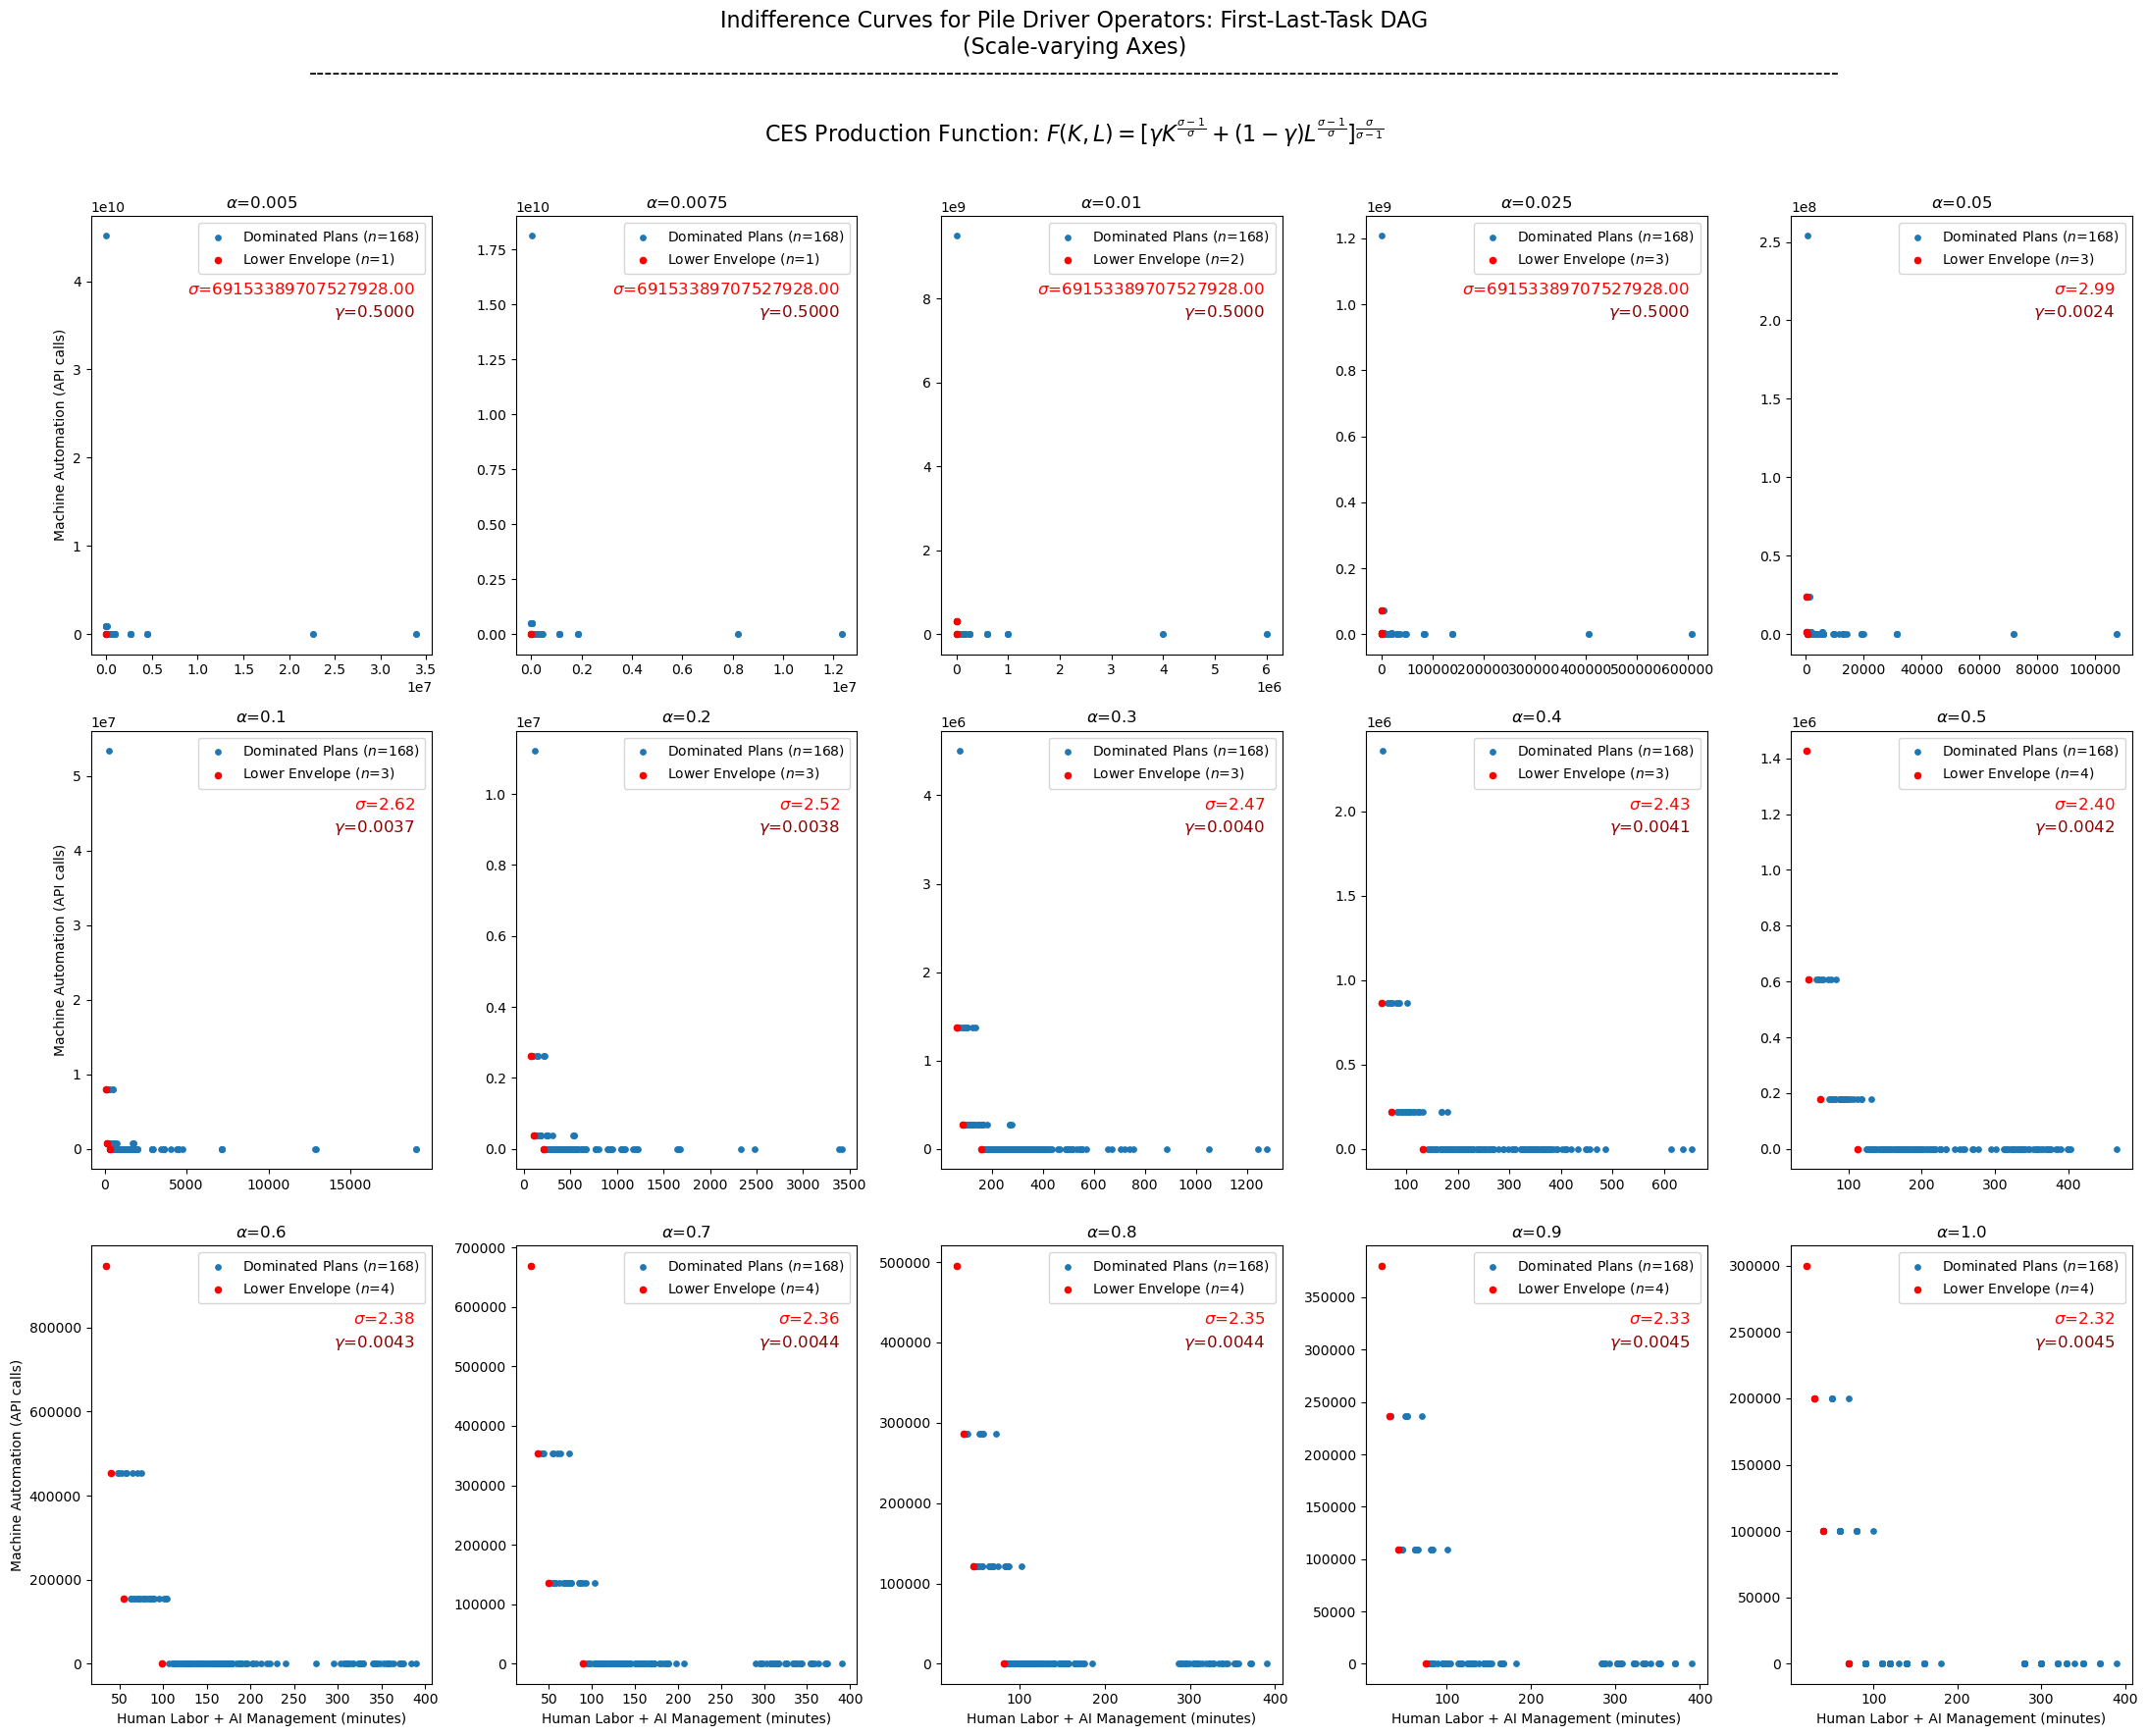

In [26]:
# Plot version 1: no scaling with lower envelope points colored red

# Create a 2x5 grid of subplots
fig, axs = plt.subplots(3, 5, figsize=(22, 18))

# Iterate over each subplot position and add a plot
for i in range(3): 
    for j in range(5): 
        alpha_index = (i % 5) * 5 + j
        my_alpha = alpha_list[alpha_index] # ignore epsilon

        # Plot full data for given alpha
        my_alpha_indiff_df = indiff_df[indiff_df['alpha']==my_alpha]
        axs[i, j].scatter(my_alpha_indiff_df.labor_cost, my_alpha_indiff_df.automation_cost, 
                          s=15, 
                          label=f'Dominated Plans (' + r'$n$' + f'={my_alpha_indiff_df.shape[0]})')
        
        # Plot lower envelope points in red
        my_alpha_lower_envelope_df = lower_envelope_df[lower_envelope_df['alpha']==my_alpha]
        axs[i, j].scatter(my_alpha_lower_envelope_df.labor_cost, my_alpha_lower_envelope_df.automation_cost, 
                          s=20, 
                          color='red', 
                          label='Lower Envelope (' + r'$n$' + f'={my_alpha_lower_envelope_df.shape[0]})')
        
        # Add elasticity and labor share for current alpha
        my_alpha_sigma = ETS_df.loc[ETS_df['alpha'] == my_alpha, 'sigma'].values[0]
        my_alpha_gamma = ETS_df.loc[ETS_df['alpha'] == my_alpha, 'gamma'].values[0]
        
        sigma_display = r'$\sigma$' + f'={my_alpha_sigma:.2f}'
        gamma_display = r'$\gamma$' + f'={my_alpha_gamma:.4f}'
        axs[i, j].text(0.95, 0.85, sigma_display, transform=axs[i, j].transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right', color='red')
        axs[i, j].text(0.95, 0.8, gamma_display, transform=axs[i, j].transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right', color='darkred')
        
        # other plot aesthetics
        axs[i, j].title.set_text(r'$\alpha$' + f'={np.round(my_alpha,4)}')
        if i == 2:
              axs[i, j].set_xlabel('Human Labor + AI Management (minutes)')
        if j == 0:
              axs[i, j].set_ylabel('Machine Automation (API calls)')
        axs[i, j].legend(loc = 'upper right')


fig.suptitle(f'Indifference Curves for {plot_title_occupation}: First-Last-Task DAG\n' +
             '(Scale-varying Axes)' +
             '\n' + 
            '------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\n\n' + 
             r'CES Production Function: $F(K,L) = [\gamma K^{\frac{\sigma-1}{\sigma}} + (1-\gamma) L^{\frac{\sigma-1}{\sigma}}]^{\frac{\sigma}{\sigma-1}} $' + 
             '\n' +
             '\n',
             fontsize=16)

plt.tight_layout()

# Save the plot
# plt.savefig(f'{occupation_folder}/indiffCurves/{occupation}_indiffCurves_FLT_totalCost_newProdFuncDef.png', dpi=300)

# Show plot
plt.show()

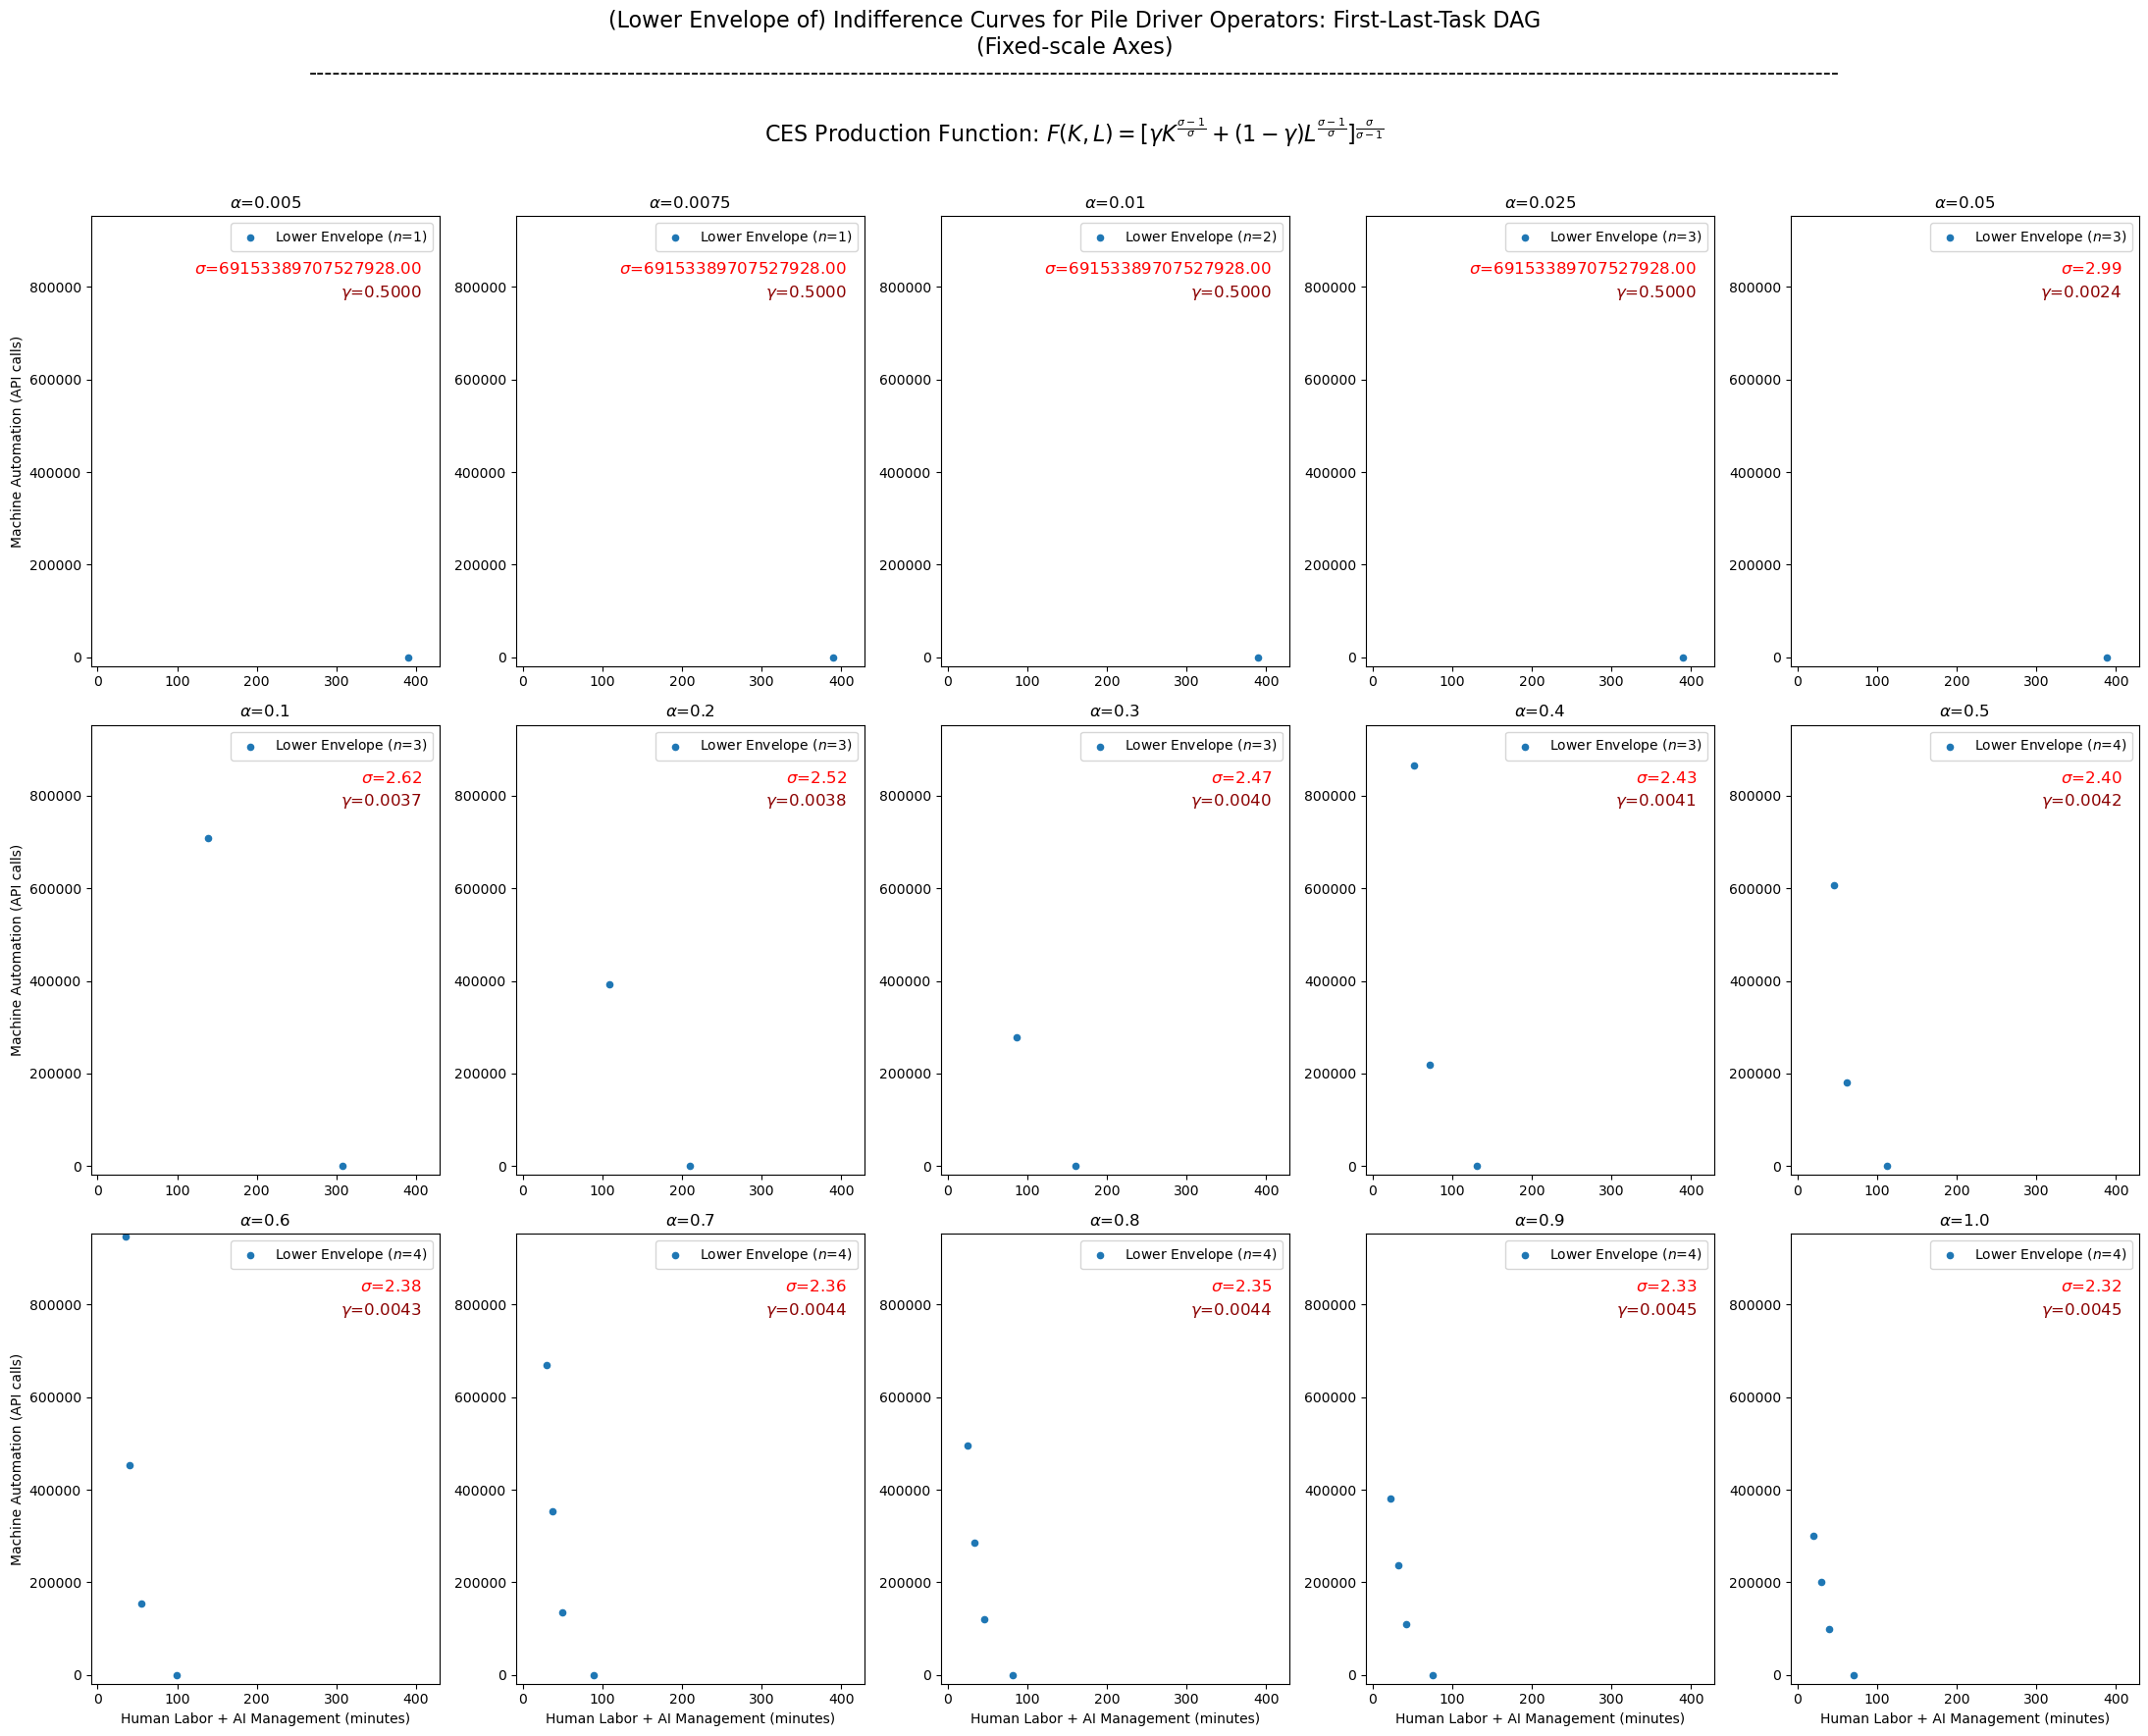

In [27]:
# Plot version 2: scaling with only lower envelope points 

# Create a 2x5 grid of subplots
fig, axs = plt.subplots(3, 5, figsize=(22, 18))

# Iterate over each subplot position and add a plot
for i in range(3): 
    for j in range(5): 
        alpha_index = (i % 5) * 5 + j
        my_alpha = alpha_list[alpha_index] # ignore epsilon

        # Plot lower envelope points in red
        my_alpha_lower_envelope_df = lower_envelope_df[lower_envelope_df['alpha']==my_alpha]
        axs[i, j].scatter(my_alpha_lower_envelope_df.labor_cost, my_alpha_lower_envelope_df.automation_cost, 
                          s=20, 
                          label='Lower Envelope (' + r'$n$' + f'={my_alpha_lower_envelope_df.shape[0]})')
        
        # Add elasticity and labor share for current alpha
        my_alpha_sigma = ETS_df.loc[ETS_df['alpha'] == my_alpha, 'sigma'].values[0]
        my_alpha_gamma = ETS_df.loc[ETS_df['alpha'] == my_alpha, 'gamma'].values[0]
        
        sigma_display = r'$\sigma$' + f'={my_alpha_sigma:.2f}'
        gamma_display = r'$\gamma$' + f'={my_alpha_gamma:.4f}'
        axs[i, j].text(0.95, 0.9, sigma_display, transform=axs[i, j].transAxes, fontsize=12, 
                       verticalalignment='top', horizontalalignment='right', color='red')
        axs[i, j].text(0.95, 0.85, gamma_display, transform=axs[i, j].transAxes, fontsize=12, 
                       verticalalignment='top', horizontalalignment='right', color='darkred')
        
        # other plot aesthetics
        axs[i, j].title.set_text(r'$\alpha$' + f'={np.round(my_alpha,4)}')
        if i == 2:
              axs[i, j].set_xlabel('Human Labor + AI Management (minutes)')
        if j == 0:
              axs[i, j].set_ylabel('Machine Automation (API calls)')
        axs[i, j].legend(loc = 'upper right')

        # set x and y limits
        xh = lower_envelope_df[lower_envelope_df.alpha==alpha_list[0]]['labor_cost'].max() * 1.1
        xl = - xh / 50
        yh = lower_envelope_df[lower_envelope_df.alpha==0.4]['automation_cost'].max() * 1.1
        yl = - yh / 50
        
        axs[i, j].set_xlim(xl, xh)
        axs[i, j].set_ylim(yl, yh)


fig.suptitle(f'(Lower Envelope of) Indifference Curves for {plot_title_occupation}: First-Last-Task DAG\n' +
             '(Fixed-scale Axes)' +
             '\n' + 
            '------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\n\n' + 
             r'CES Production Function: $F(K,L) = [\gamma K^{\frac{\sigma-1}{\sigma}} + (1-\gamma) L^{\frac{\sigma-1}{\sigma}}]^{\frac{\sigma}{\sigma-1}} $' + 
             '\n' +
             '\n',
             fontsize=16)

plt.tight_layout()

# Save the plot
# plt.savefig(f'{occupation_folder}/indiffCurves/{occupation}_indiffCurves_FLT_totalCost_newProdFuncDef.png', dpi=300)

# Show plot
plt.show()

In [28]:
lower_envelope_df.sort_values(by=['alpha', 'labor_cost', 'automation_cost']).head(40)

,alpha,execution_plan,human_tasks,managed_tasks,automated_tasks,human_labor_cost,management_cost,automation_cost,labor_cost,total_cost,min_total_cost_flag
0,0.0050,"[[0], [1], [2], [3], [4]]","[0, 1, 2, 3, 4]",[],[],390,0.0000,0.000000e+00,390.0000,390.000000,True
1,0.0075,"[[0], [1], [2], [3], [4]]","[0, 1, 2, 3, 4]",[],[],390,0.0000,0.000000e+00,390.0000,390.000000,True
3,0.0100,"[[0, 2, 3], [1], [4]]","[1, 4]",[[3]],"[[0, 2]]",60,316.2278,3.169786e+08,376.2278,32074.091649,False
2,0.0100,"[[0], [1], [2], [3], [4]]","[0, 1, 2, 3, 4]",[],[],390,0.0000,0.000000e+00,390.0000,390.000000,True
6,0.0250,"[[0, 2, 3], [1], [4]]","[1, 4]",[[3]],"[[0, 2]]",60,159.0541,7.316881e+07,219.0541,7535.934931,False
5,0.0250,"[[0], [1], [2, 3], [4]]","[0, 1, 4]",[[3]],[[2]],90,159.0541,2.300123e+06,249.0541,479.066364,False
4,0.0250,"[[0], [1], [2], [3], [4]]","[0, 1, 2, 3, 4]",[],[],390,0.0000,0.000000e+00,390.0000,390.000000,True
9,0.0500,"[[0, 2, 3], [1], [4]]",[1],"[[3], 4]","[[0, 2]]",30,123.1080,2.413671e+07,153.1080,2566.778535,False
8,0.0500,"[[0], [1], [2, 3], [4]]","[0, 1]","[[3], 4]",[[2]],60,123.1080,1.276073e+06,183.1080,310.715293,True
7,0.0500,"[[0], [1], [2], [3], [4]]","[0, 1, 2, 3]",[4],[],360,28.5339,0.000000e+00,388.5339,388.533900,False
